In [1]:
import requests
gene_id = 'ENSG00000165269'
efo_id = 'EFO_0003843'
size = '10000'
url = (
    'https://platform-api.opentargets.io/v3/platform/public/evidence/filter?size=' 
    + size 
    + '&datasource=chembl&fields=disease.efo_info&fields=drug&fields=evidence&fields=target&fields=access_level&disease='
    + efo_id 
    + '&expandefo=true'
) 
r = requests.get(url)

data = r.json()

all_drugs_data = data['data']

print(len(all_drugs_data))

10000


In [2]:
drugs_data_simple = []

for entry in all_drugs_data:
    target_symbol = entry['target']['gene_info']['symbol']
    disease_label = entry['disease']['efo_info']['label']
    drug_name = entry['drug']['molecule_name']
    drug_phase = entry['evidence']['drug2clinic']['clinical_trial_phase']['numeric_index']
    drug_status = entry['evidence']['drug2clinic'].get('status', 'n/a')
    drug_obj = {
        'target': target_symbol,
        'disease': disease_label,
        'drug': drug_name,
        'phase': drug_phase,
        'status': drug_status,
    }
    drugs_data_simple.append(drug_obj)

print(len(drugs_data_simple))
print(drugs_data_simple[0])

10000
{'target': 'OPRM1', 'disease': 'pain', 'drug': 'FENTANYL', 'phase': 4, 'status': 'Completed'}


In [3]:
import pandas as pd

drugs_df = pd.DataFrame(drugs_data_simple)

print(len(drugs_df))
drugs_df.head()

10000


,disease,drug,phase,status,target
0,pain,FENTANYL,4,Completed,OPRM1
1,pain,ETORICOXIB,4,Completed,PTGS2
2,pain,HYDROMORPHONE,4,n/a,OPRM1
3,pain,ROPIVACAINE,4,Recruiting,SCN3A
4,pain,ROPIVACAINE,4,Not yet recruiting,SCN3A


In [4]:
cols_to_aggregate = ['disease', 'drug', 'phase', 'status', 'target']

aggregated_drugs_df = drugs_df.groupby(cols_to_aggregate).size().reset_index(name='num_ev_strings').sort_values(by='num_ev_strings', ascending=False)

print(len(aggregated_drugs_df))
aggregated_drugs_df.head()

1602


,disease,drug,phase,status,target,num_ev_strings
460,pain,ACETAMINOPHEN,4,n/a,TRPV1,465
458,pain,ACETAMINOPHEN,4,n/a,PTGS1,464
459,pain,ACETAMINOPHEN,4,n/a,PTGS2,457
457,pain,ACETAMINOPHEN,4,n/a,FAAH,457
739,pain,HYDROCODONE,4,n/a,OPRK1,296


In [5]:
file_name = 'reports/aggregated_drug_evidence_' + efo_id + '.csv'

aggregated_drugs_df.to_csv(file_name, encoding='utf-8')

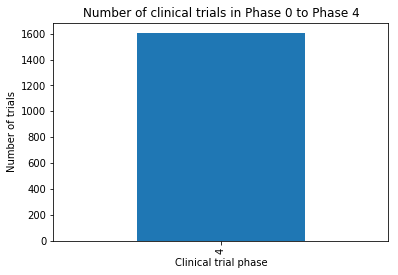

In [7]:
import matplotlib.pyplot as plt

ax = aggregated_drugs_df['phase'].value_counts().plot(kind='bar', 
                                                      title="Number of clinical trials in Phase 0 to Phase 4")

ax.set_xlabel("Clinical trial phase")
ax.set_ylabel("Number of trials")
plt.show()

In [45]:
import requests
import pandas as pd
import math

diseases = [
#     {
#         'efo_id': 'EFO_0003843',
#         'efo_label': 'pain'
#     },
#     {
#         'efo_id': 'EFO_0000305',
#         'efo_label': 'breast carcinoma'
#     },
#     {
#         'efo_id': 'EFO_0000400',
#         'efo_label': 'diabetes mellitus'
#     }, 
    {
        'efo_id': 'EFO_0001071',
        'efo_label': 'lung carcinoma'
    }
    
#     {
#         'efo_id': 'EFO_0000270',
#         'efo_label': 'asthma'
#     },
#     {
#         'efo_id': 'EFO_0003086',
#         'efo_label': 'kidney disease'
#     },
#     {
#         'efo_id': 'EFO_0003885',
#         'efo_label': 'multiple sclerosis'
#     },
#     {
#         'efo_id': 'EFO_0003767',
#         'efo_label': 'inflammatory bowel disease'
#     },  
]

size = '10000'

summary_report_data = []

for disease in diseases:
    
    print('*****')
    print('Running aggregation for %s' % (disease['efo_label']))
    
    url = (
        'https://platform-api.opentargets.io/v3/platform/public/evidence/filter?size=' 
        + size 
        + '&datasource=chembl&fields=disease.efo_info&fields=drug&fields=evidence&fields=target&fields=access_level&disease='
        + disease['efo_id'] 
        + '&expandefo=true'
    ) 
    
    r = requests.get(url)
    
    data = r.json()
    
    all_drugs_data = data['data']
    
    if data['total'] > 10000:
        num_additional_api_calls_to_make = math.ceil(data['total'] / 10000) - 1
        next_params = [data['next'][0], data['next'][1]]
        for i in range(num_additional_api_calls_to_make):
            print('Running additional API call for %s' % (disease['efo_label']))
            print(next_params)
            url = (
                'https://platform-api.opentargets.io/v3/platform/public/evidence/filter?size=' 
                + size 
                + '&datasource=chembl&fields=disease.efo_info&fields=drug&fields=evidence&fields=target&fields=access_level&disease='
                + disease['efo_id'] 
                + '&expandefo=true' 
                + '&next='
                + str(next_params[0])
                + '&next='
                + str(next_params[1])
            )
            r = requests.get(url)
            data = r.json()
            all_drugs_data.extend(data['data'])
            if 'next' in data:
                next_params = [data['next'][0], data['next'][1]]
        
    print('Total number of evidence strings from API: %s' % len(all_drugs_data))
    
    drugs_data_simple = []
    
    for entry in all_drugs_data:
        target_symbol = entry['target']['gene_info']['symbol']
        disease_label = entry['disease']['efo_info']['label']
        drug_name = entry['drug']['molecule_name']
        drug_phase = entry['evidence']['drug2clinic']['clinical_trial_phase']['numeric_index']
        drug_status = entry['evidence']['drug2clinic'].get('status', 'n/a')
        drug_obj = {
            'target': target_symbol,
            'disease': disease_label,
            'drug': drug_name,
            'phase': drug_phase,
            'status': drug_status,
        }
        drugs_data_simple.append(drug_obj)
    
    print('Number of evidence strings in list with simple data: %s' % len(all_drugs_data))
    
    print(drugs_data_simple[0])
    
    drugs_df = pd.DataFrame(drugs_data_simple)
    
    cols_to_aggregate = ['disease', 'drug', 'phase', 'status', 'target']

    aggregated_drugs_df = drugs_df.groupby(cols_to_aggregate).size().reset_index(name='num_ev_strings').sort_values(by='num_ev_strings', ascending=False)

    print('Number of evidence strings aggregated: %s' % len(aggregated_drugs_df))
    
    file_name = 'reports/aggregated_drug_evidence_' + disease['efo_label'] + '.csv'

    aggregated_drugs_df.to_csv(file_name, index=False, encoding='utf-8')
    
    percentage_difference = round(((len(aggregated_drugs_df) - len(all_drugs_data)) / len(all_drugs_data) * 100), 2) 
    
    summary_report_row = {
        'disease': disease['efo_label'],
        'efo_id': disease['efo_id'],
        'evidence_strings_all': data['total'],  
        'evidence_strings_api_response': len(all_drugs_data),
        'evidence_strings_aggregated': len(aggregated_drugs_df),
        'percentage_difference': percentage_difference
    }
    
    summary_report_data.append(summary_report_row)

summary_report_df = pd.DataFrame(summary_report_data)

summary_report_file_name = 'reports/summary_report_all_diseases.csv'

summary_report_df.to_csv(summary_report_file_name, index=False, encoding='utf-8')
        

*****
Running aggregation for lung carcinoma
Running additional API call for lung carcinoma
[0.2, '94329158fd4d6813665316c4ec73d2a1']
Running additional API call for lung carcinoma
[0.1, '4ae90439093638689a3fe822ade7f704']
Total number of evidence strings from API: 21366
Number of evidence strings in list with simple data: 21366
{'target': 'POLD4', 'disease': 'non-small cell lung carcinoma', 'drug': 'GEMCITABINE', 'phase': 4, 'status': 'n/a'}
Number of evidence strings aggregated: 6907
